In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy import integrate

basepath = "/Users/puyuange/Documents/uni stuff/Non-Trivial/NTFproject-Python/" 

In [2]:
# Disease parameters

beta = 0.1
c = 3
T_incubation = 10
sigma = 1/T_incubation
T_recovery = 10
gamma = 1/T_recovery
r = 1 # Maximum radius travellable by large droplet
A = 25

In [3]:
# Nodes

# node = [id, S, E, I, R, C]
n1 = np.array([1, 100000, 750, 0, 0]).astype(float)
n2 = np.array([2, 100000, 0, 0, 0]).astype(float)
n3 = np.array([3, 100000, 0, 0, 0]).astype(float)
n4 = np.array([4, 100000, 0, 0, 0]).astype(float)

nodes = [n1, n2, n3, n4]
nodes_num = len(nodes)

In [4]:
# lst = [x for x in nodes if not (x==n1).all()] # remove specific node from node list

In [5]:
# Edge Matrices

flow = np.array([[0, 50, 0, 0],
                 [0, 0, 50, 0],
                 [0, 0, 0, 50],
                 [50, 0, 0, 0]])

freq = np.array([[1, 1, 1, 1],
                 [1, 1, 1, 1],
                 [1, 1, 1, 1],
                 [1, 1, 1, 1]])

univ = np.array([[0, 0.1, 0, 0],
                 [0, 0, 0.1, 0],
                 [0, 0, 0, 0.1],
                 [0.1, 0, 0, 0]])

partial = np.array([[0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1, 0, 0, 0]])

# duration = np.array([[0, 0, 0, 0],
#                     [0, 0, 0, 0],
#                     [0, 0, 0, 0],
#                     [0, 0, 0, 0]])


def id(node):
    return node[0]

def edge(matrix, fromnode, tonode): # Edge which flows i to j
    i = id(fromnode)
    i = int(i-1)
    j = id(tonode)
    j = int(j-1)
    return matrix[i][j]

In [6]:
#s, e, i and r
def N(node):
    return sum(node[1::])

def S(node):
    return node[1]

def E(node):
    return node[2]

def I(node):
    return node[3]

def R(node):
    return node[4]

In [7]:
def delta_seir(node):
    
    global l
    global beta
    global c
    global sigma
    global gamma

    dS = - ((beta * c) * S(node) * I(node)) / N(node)
    dE = ((beta * c) * S(node) * I(node)) / N(node) - sigma * E(node)
    dI = sigma * E(node) - gamma * I(node)
    dR = gamma * I(node)

    return np.array([0, dS, dE, dI, dR])

def delta_out(fromnode, tonode):

    global flow
    global univ
    global partial

    F = edge(flow, fromnode, tonode)
    U = edge(univ, fromnode, tonode)
    P = edge(partial, fromnode, tonode)

    FS = (U * S(fromnode) * F)/N(fromnode)
    FE = (U * E(fromnode) * F)/N(fromnode)
    FI = (U * P * I(fromnode) * F)/N(fromnode)
    FR = (U * R(fromnode) * F)/N(fromnode)

    return np.array([0, FS, FE, FI, FR])

def infected_enroute(fromnode, tonode):
    
    global flow
    global freq
    global univ
    global partial
    global A
    global r
    global beta

    F = edge(flow, fromnode, tonode)
    f = edge(freq, fromnode, tonode)
    U = edge(univ, fromnode, tonode)
    P = edge(partial, fromnode, tonode)

    s = (U * F * S(fromnode))/N(fromnode)
    i = (U * P * F * I(fromnode))/N(fromnode)

    L = s * (1-np.exp((-i * np.pi * np.square(r))/A)) * beta
    # later replace beta with 1-exp(-kT)
    
    delta_array = delta_out(fromnode, tonode)
    
    delta_array[1] = delta_array[1] - L
    delta_array[2] = delta_array[2] + L

    return delta_array

In [8]:
def delta_travel(node, nodes):
    intake = [0, 0, 0, 0, 0]
    outtake = [0, 0, 0, 0, 0]
    for n in [x for x in nodes if not (x==node).all()]:
        intake += infected_enroute(n, node)
        outtake += delta_out(node, n)
    return intake - outtake

In [9]:
def update_node_status(node, nodes):
    node += delta_seir(node)
    node += delta_travel(node, nodes)
    return node

In [10]:
def ESI(df_list, t_h):
    cumsum = 0
    sumpop = 0
    for df in df_list:
        cum = df.query("t == @t_h")["C"].item()
        cumsum += cum
        pop = df.query("t == @t_h")["N"].item()
        sumpop += pop

    return cumsum/sumpop

def disruption_constF(df_list, t_h, F_matrix, P_matrix, U_matrix): # constant flow rate
    total_flow = 0
    disrupted = 0

    lst = list(range(1, len(df_list) + 1))

    for i in lst:
        fromid = i-1
        df = df_list[fromid]

        exclu_lst = lst[:]
        exclu_lst.remove(i)


        for j in exclu_lst:
            toid = j-1
            F = F_matrix[fromid][toid]
            P = P_matrix[fromid][toid]
            U = U_matrix[fromid][toid]

            total_flow += F * t_h

            df["i"] = df.apply(lambda x: np.divide(x.I, x.N), axis=1)
            df["Irestrict"] = df["i"].apply(lambda x: F*(1-P*U)*x)
            df["otherrestrict"] = df["i"].apply(lambda x: F*(1-U)*(1-x))
            disrupted += df["Irestrict"].sum() + df["otherrestrict"].sum()

        df = None
    
    return disrupted/total_flow
    


In [11]:
def plot_SEIR(df, ax, title):
    ax.set_title(title)
    ax.plot(df["t"], df["S"], color="blue")
    ax.plot(df["t"], df["E"], color="orange")
    ax.plot(df["t"], df["I"], color="red")
    ax.plot(df["t"], df["R"], color="green")
    ax.plot(df["t"], df["C"], color="red", linestyle="dashed")

In [13]:
# Simulate

def sim(nodes, time_horizon):
    
    nodes_num = len(nodes)
    rowslist = []

    # Initial Values
    for i in range(0, nodes_num):
        initrow = [{"t": 0, "S": S(nodes[i]), "E": E(nodes[i]), "I": I(nodes[i]), "R":R(nodes[i])}]
        rowslist.append(initrow)


    for t in range(1, time_horizon):
        for j in range(0, nodes_num):
            nodes[j] = update_node_status(nodes[j], nodes)
            insertrow = {"t": t, "S": S(nodes[j]), "E": E(nodes[j]), "I": I(nodes[j]), "R":R(nodes[j])}
            rowslist[j].append(insertrow)
        
    dflist = []

    for k in range(0, nodes_num):
        df = pd.DataFrame(rowslist[k])
        df["N"] = df["S"] + df["E"] + df["I"] + df["R"]
        df["C"] = df["I"] + df["R"]
        dflist.append(df)

    return dflist



dflist = sim(nodes, 325)
df1 = dflist[0]
df2 = dflist[1]
df3 = dflist[2]
df4 = dflist[3]


In [14]:
print(disruption_constF(dflist, 324, flow, partial, univ))

0.9027777777777778


In [15]:
epidemic_spreading_index = ESI(dflist, 324)
print(epidemic_spreading_index)

0.9001867664698762


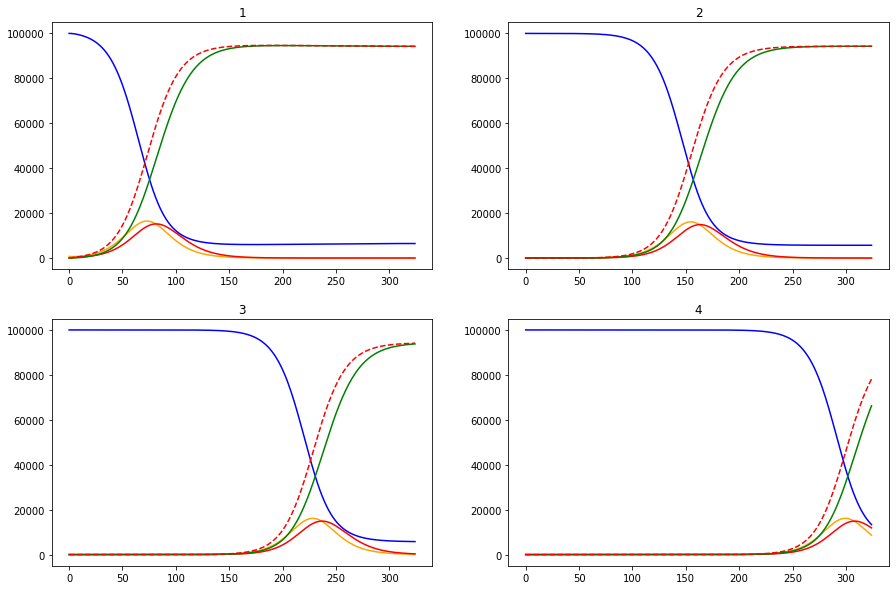

In [17]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plot_SEIR(df1, ax1, "1")
plot_SEIR(df2, ax2, "2")
plot_SEIR(df3, ax3, "3")
plot_SEIR(df4, ax4, "4")

plt.show()
